 ---

# Neural Dependency Parser
 
---

Dependency Parsing is the process to analyze the grammatical structure in a sentence and find out related words as well as the type of the relationship between them.

Each relationship:
1. Has one **head** and a **dependent** that modifies the **head**.
2. Is labeled according to the nature of the dependency between the **head** and the **dependent**. These labels can be found at [Universal Dependency Relations](https://universaldependencies.org/u/dep/).

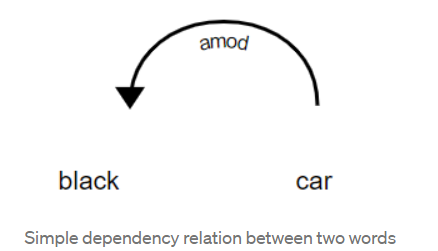

In the above diagram, there exists a relationship between *car* and *black* because *black* modifies the meaning of *car*. Here, *car* acts as the **head** and *black* is a **dependent** of the **head**. The nature of the relationship here is **amod** which stands for “Adjectival Modifier”. It is an adjective or an adjective phrase that modifies a noun.


There are multiple types of dependency parsers, including transition-based parsers, graph-based parsers, and feature-based parsers. The following implementation will be a *transition-based* parser, which incrementally builds up a parse one step at a time. At every step it maintains a *partial parse*, which is represented as follows:

* A *stack* of words that are currently being processed.
* A *buffer* of words yet to be processed.
* A list of *dependencies* predicted by the parser.

Initially, the stack only contains **ROOT**, the dependencies list is empty, and the buffer contains all words of the sentence in order. At each step, the parser applies a *transition* to the partial parse until its buffer is empty and the stack size is 1.
The following transitions can be applied:

* *SHIFT*: removes the first word from the buffer and pushes it onto the stack.



* *LEFT-ARC*: marks the second (second most recently added) item on the stack as a dependent of the first item and removes the second item from the stack, adding a *first\_word* $\rightarrow$ *second\_word* dependency to the dependency list.



* *RIGHT-ARC*: marks the first (most recently added) item on the stack as a dependent of the second item and removes the first item from the stack, adding a *second\_word* $\rightarrow$ *first\_word* dependency to the dependency list.



On each step, your parser will decide among the three transitions using a neural network classifier.

In [5]:
import numpy as np
from datetime import datetime
import os
import pickle
import math
import time


import torch
from tqdm import tqdm

#from parser_model import ParserModel
from utils.parser_utils import minibatches, load_and_preprocess_data, AverageMeter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  
    print(f"Running on GPU {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on GPU GeForce MX250


In [2]:
class ParserModel(nn.Module):
    """ Feedforward neural network with an embedding layer and two hidden layers.
    The ParserModel will predict which transition should be applied to a
    given partial parse configuration.

    """
    def __init__(self, embeddings, n_features=36,
        hidden_size=200, n_classes=3, dropout_prob=0.5):
        """ Initialize the parser model.

        @param embeddings (ndarray): word embeddings (num_words, embedding_size)
        @param n_features (int): number of input features
        @param hidden_size (int): number of hidden units
        @param n_classes (int): number of output classes
        @param dropout_prob (float): dropout probability
        """
        super(ParserModel, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size = embeddings.shape[1]
        self.hidden_size = hidden_size
        self.embeddings = nn.Parameter(torch.tensor(embeddings))



        self.embed_to_hidden_weight = nn.Parameter(torch.Tensor(self.embed_size * self.n_features, self.hidden_size))
        nn.init.xavier_uniform_(self.embed_to_hidden_weight, gain=1)
        self.embed_to_hidden_bias = nn.Parameter(torch.Tensor(self.hidden_size))
        nn.init.uniform_(self.embed_to_hidden_bias)
        
        self.dropout = nn.Dropout(self.dropout_prob)

        self.hidden_to_logits_weight = nn.Parameter(torch.Tensor(self.hidden_size, self.n_classes))
        nn.init.xavier_uniform_(self.hidden_to_logits_weight, gain=1)
        self.hidden_to_logits_bias = nn.Parameter(torch.Tensor(self.n_classes))
        nn.init.uniform_(self.hidden_to_logits_bias)


    def embedding_lookup(self, w):
        """ Utilize `w` to select embeddings from embedding matrix `self.embeddings`
            @param w (Tensor): input tensor of word indices (batch_size, n_features)

            @return x (Tensor): tensor of embeddings for words represented in w
                                (batch_size, n_features * embed_size)
        """


        x = torch.index_select(self.embeddings, 0, w.view(-1))
        x = x.view(w.size()[0], -1)

        ### END YOUR CODE
        return x


    def forward(self, w):
        """ Run the model forward.

        @param w (Tensor): input tensor of tokens (batch_size, n_features)

        @return logits (Tensor): tensor of predictions (output after applying the layers of the network)
                                 without applying softmax (batch_size, n_classes)
        """


        x = self.embedding_lookup(w)
        x = x @ self.embed_to_hidden_weight + self.embed_to_hidden_bias
        x = F.relu(x)
        x = self.dropout(x)
        logits = x @ self.hidden_to_logits_weight + self.hidden_to_logits_bias

        ### END YOUR CODE
        return logits

In [7]:

def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    """ Train the neural dependency parser.

    @param parser (Parser): Neural Dependency Parser
    @param train_data ():
    @param dev_data ():
    @param output_path (str): Path to which model weights and results are written.
    @param batch_size (int): Number of examples in a single batch
    @param n_epochs (int): Number of training epochs
    @param lr (float): Learning rate
    """
    best_dev_UAS = 0


    optimizer = optim.Adam(parser.model.parameters(), lr)
    loss_func = nn.CrossEntropyLoss()

    ### END YOUR CODE

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    """ Train the neural dependency parser for single epoch.

    @param parser (Parser): Neural Dependency Parser
    @param train_data ():
    @param dev_data ():
    @param optimizer (nn.Optimizer): Adam Optimizer
    @param loss_func (nn.CrossEntropyLoss): Cross Entropy Loss Function
    @param batch_size (int): batch size

    @return dev_UAS (float): Unlabeled Attachment Score (UAS) for dev data
    """
    parser.model.train() # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            optimizer.zero_grad()   # remove any baggage in the optimizer
            loss = 0. # store loss for this batch here
            train_x = torch.from_numpy(train_x).long()
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()



            logits = parser.model.forward(train_x)
            loss = loss_func(logits, train_y)
            loss.backward()
            optimizer.step()


            ### END YOUR CODE
            prog.update(1)
            loss_meter.update(loss.item())

    print ("Average Train Loss: {}".format(loss_meter.avg))

    print("Evaluating on dev set",)
    parser.model.eval() # Places model in "eval" mode, i.e. don't apply dropout layer
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS


In [12]:

    print(80 * "=")
    print("INITIALIZING")
    print(80 * "=")
    parser, embeddings, train_data, dev_data, test_data = load_and_preprocess_data()

    start = time.time()
    model = ParserModel(embeddings)
    parser.model = model
    print("took {:.2f} seconds\n".format(time.time() - start))

    print(80 * "=")
    print("TRAINING")
    print(80 * "=")
    output_dir = "results/{:%Y%m%d_%H%M%S}/".format(datetime.now())
    output_path = output_dir + "model.weights"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005)

INITIALIZING
Loading data...
took 3.53 seconds
Building parser...
took 0.06 seconds
Loading pretrained embeddings...
took 5.78 seconds
Vectorizing data...
took 0.11 seconds
Preprocessing training data...


  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

took 2.17 seconds
took 0.00 seconds

TRAINING
Epoch 1 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.67it/s]


Average Train Loss: 0.6756279766559601
Evaluating on dev set


125250it [00:00, 7830442.78it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 51.16
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.11it/s]


Average Train Loss: 0.3565458661566178
Evaluating on dev set


125250it [00:00, 5445425.93it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 56.62
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.91it/s]


Average Train Loss: 0.29550182819366455
Evaluating on dev set


125250it [00:00, 6262953.93it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 58.08
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.48it/s]


Average Train Loss: 0.2567308604096373
Evaluating on dev set


125250it [00:00, 5693656.19it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 59.84
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 16.63it/s]


Average Train Loss: 0.23241431980083385
Evaluating on dev set


125250it [00:00, 6592914.03it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 61.68
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.57it/s]


Average Train Loss: 0.21062523933748403
Evaluating on dev set


125250it [00:00, 7369007.94it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 63.52
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.81it/s]


Average Train Loss: 0.1923650565246741
Evaluating on dev set


125250it [00:00, 6958837.70it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 63.63
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.88it/s]


Average Train Loss: 0.17788331055392823
Evaluating on dev set


125250it [00:00, 8947839.01it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 64.43
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 18.06it/s]


Average Train Loss: 0.16453051877518496
Evaluating on dev set


125250it [00:00, 6263028.60it/s]                                                                                       
  0%|                                                                                           | 0/48 [00:00<?, ?it/s]

- dev UAS: 65.58
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.88it/s]


Average Train Loss: 0.1524593330298861
Evaluating on dev set


125250it [00:00, 5693841.32it/s]                                                                                       

- dev UAS: 65.63
New best dev UAS! Saving model.



In [13]:
print(80 * "=")
print("TESTING")
print(80 * "=")
print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_data)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 6959206.44it/s]                                                                                       

- test UAS: 67.64
Done!
